In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'zeta': 1 - (-.6)**2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       zeta=true_params['zeta'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                  theta=true_params['equity_price'])})

## We start by examining the distributions of simulated data

In [9]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [10]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

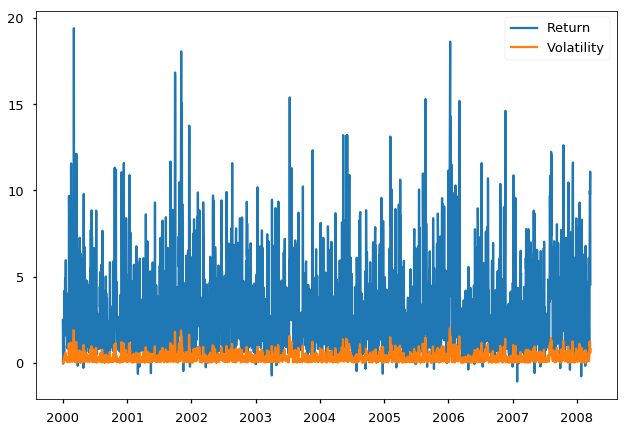

In [11]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


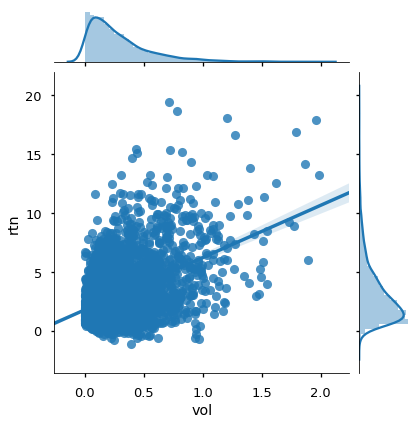

In [12]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [13]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.293242,3.063666
std,0.269501,2.521778
min,0.000126,-1.100358
25%,0.099695,1.283954
50%,0.216289,2.377064
75%,0.399539,4.123161
max,1.983155,19.423809


## I now estimate all of the parameters

In [14]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [15]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params_strong_id, data_arr),
                                      total=len(data_arr)))

In [16]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [17]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

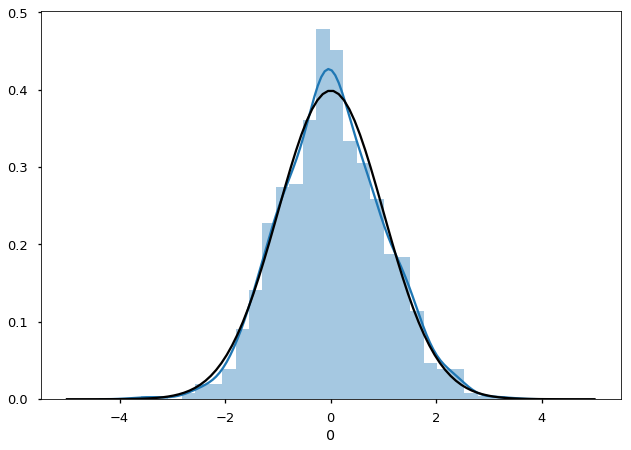

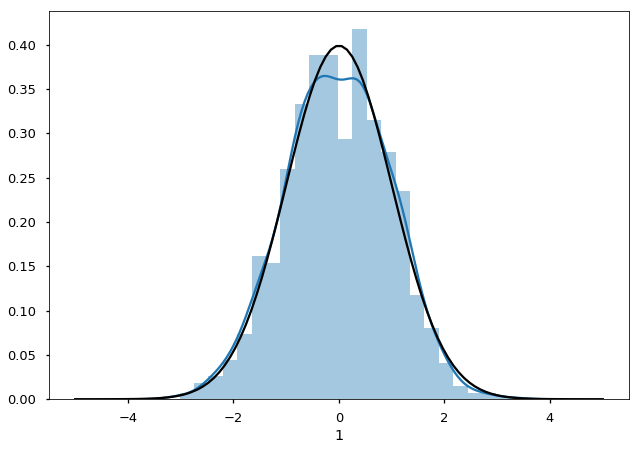

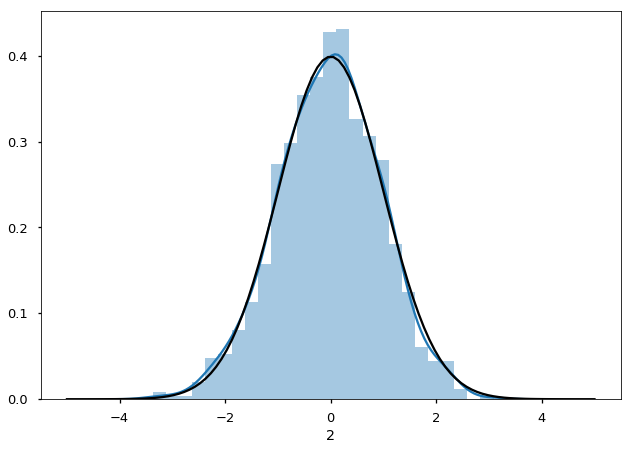

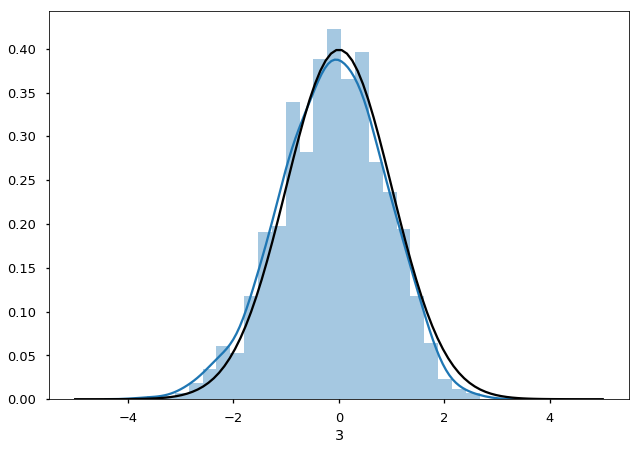

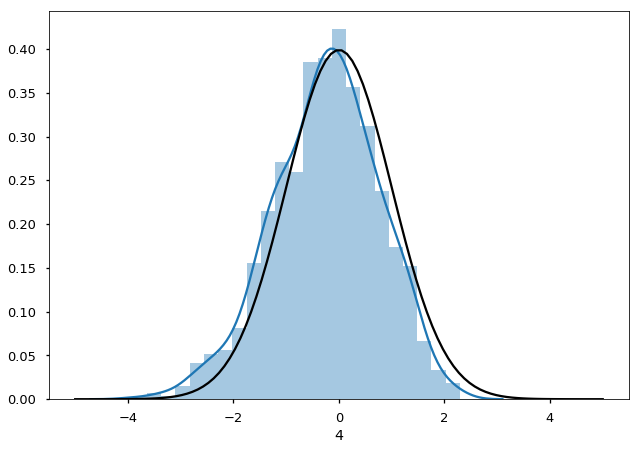

In [18]:
for i in range(5):
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment_data.iloc[:,i], ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

Text(0.5,0,'delta')

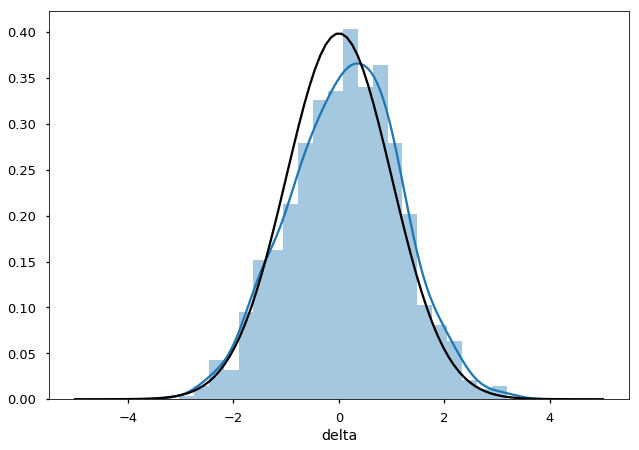

In [19]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

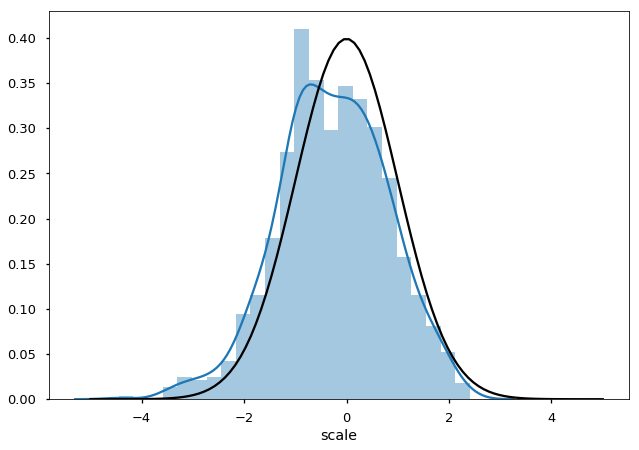

In [20]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

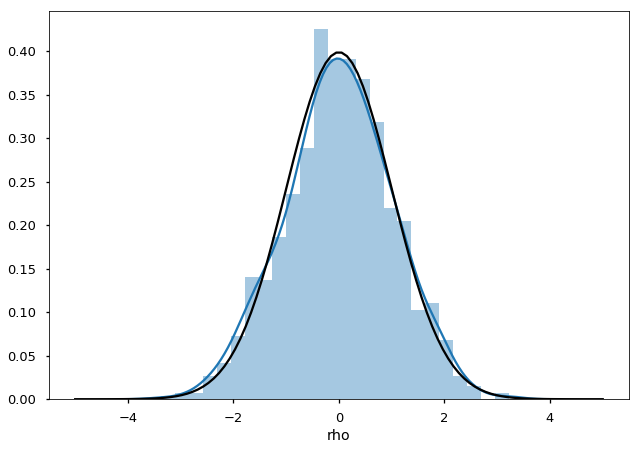

In [21]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

Text(0.5,0,'equity price')

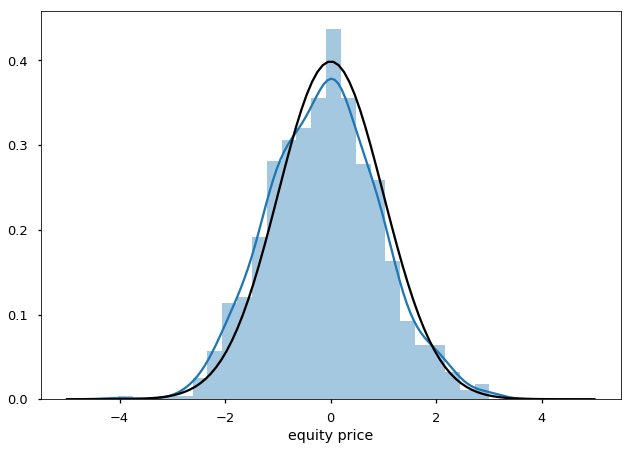

In [22]:
equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['equity_price'] - true_params['equity_price']) / 
              np.sqrt(cov.loc['equity_price', 'equity_price']) for est, cov in est_arr], ax=equity_price_ax)
equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
equity_price_ax.set_xlabel('equity price')

Text(0.5,0,'vol_price')

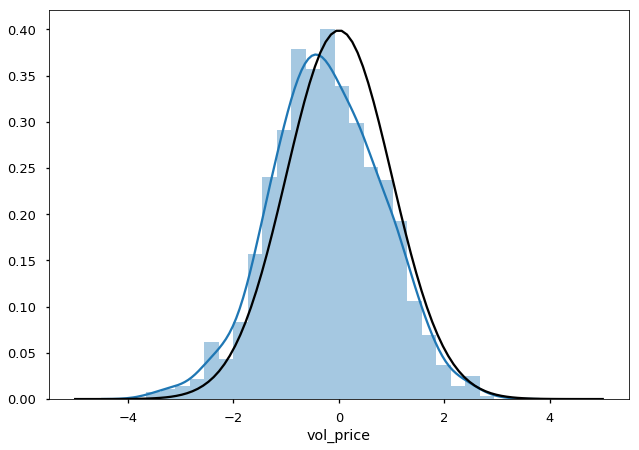

In [23]:
vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['vol_price'] - true_params['vol_price']) / 
              np.sqrt(cov.loc['vol_price', 'vol_price']) for est, cov in est_arr], ax=vol_price_ax)
vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
vol_price_ax.set_xlabel('vol_price')

(-10, 10)

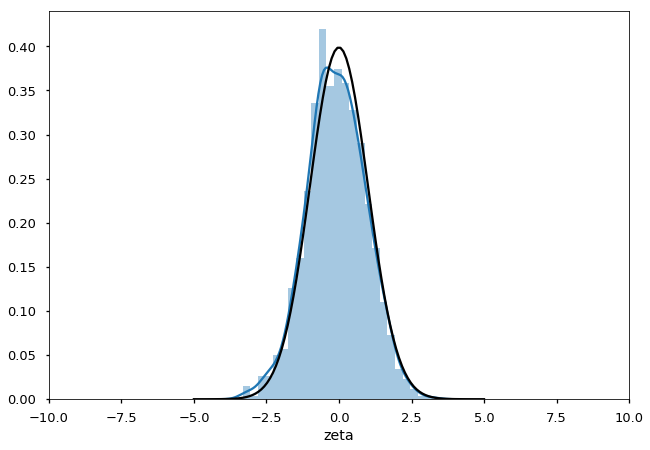

In [24]:
zeta_fig, zeta_ax = mpl.pyplot.subplots()
sns.distplot([(est['zeta'] - true_params['zeta']) / np.sqrt(cov.loc['zeta', 'zeta'])
              for est, cov in est_arr], ax=zeta_ax)
zeta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
zeta_ax.set_xlabel('zeta')
zeta_ax.set_xlim([-10,10])